<a href="https://colab.research.google.com/github/nulllpointer/custom_object_detection_colab/blob/master/object_custom_tf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Object Detection with custom dataset in Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com) using [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Requirements are only dataset images and annotations file.**

The code is compatible with Object Detection api updates in July 13 2018 [release](https://github.com/tensorflow/models/tree/master/research/object_detection#july-13-2018).

**Colab Runtime type: Python2, GPU enabled.**



#Create Dataset

I generated dataset annotations with [LabelImg](https://github.com/tzutalin/labelImg).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:

1.   Collect various pictures of objects to detect
2.   Rename image filenames with format `objectclass_seq.jpg`
3.   In LabelImg create annotation files. LabelImg saves annotations as XML files in PASCAL VOC format
4.   Create dataset.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
dataset.zip file
|-images directory
  |-image files (filename format: objectclass_seq.jpg)
|-annotations directory
  |-xmls directory
    |-annotation files (filename format: objectclass_seq.xml)
```

Where `objectclass` is the class name, `seq` is a sequence number (001, 002, 003, ...)

Check my dataset.zip file as dataset example.


# Install required packages


In [71]:
# %cd ~
# !rm -r *

import fnmatch

image_count= len(fnmatch.filter(os.listdir('/root/datalab/images'), '*.jpg'))
batch=image_count/24
print(str(batch))




307


In [2]:
%cd
#  run initially 
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

#  run initially 
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip


%cd ~/models/research

!protoc object_detection/protos/*.proto --python_out=.

import os
# os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/setup.py'
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim'


!python object_detection/builders/model_builder_test.py

/root
/root/models/research
W0727 17:46:38.128067 140233413592960 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0727 17:46:38.376101 140233413592960 deprecation_wrapper.py:119] From /root/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0727 17:46:38.429475 140233413592960 deprecation_wrapper.py:119] From /root/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

Running tests under Python 2.7.15: /usr/bin/python2
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_e

In [73]:
%cd ~/datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('label_map.pbtxt', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/root/datalab


Saving label_map.pbtxt to label_map.pbtxt
saved file label_map.pbtxt


# Download and extract dataset


*   Change name attribute in label_map, accordingly with objectclass filename.
*   Substitute fileId value with your dataset.zip id in Google Drive. See [here](https://stackoverflow.com/a/48855034/9250875) my answer to get file id.

In [74]:
%mkdir -p ~/datalab 
%cd ~/datalab

# !echo "item {id: 1 name: 'Abyssinian'}" > label_map.pbtxt
# or
# %cd ~
# %cd ..
# !mv label_map.pbtxt /root/datalab 
%cd ~/datalab



fileId = '1rtChiD59mt2p93zU34DN_OSYgnza6reG'

# fileId = '1mJMDXT00O7TbOrwR7XGv5gtkKLajXBsI'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

W0725 20:44:59.076436 139868691867520 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth


/root/datalab
/root/datalab
Extracted zip file 1rtChiD59mt2p93zU34DN_OSYgnza6reG.zip


#Empty png files
Create empty png mask files to avoid error in create_pet_tf_record.py, they are not used in training model.

In [75]:
# !cat ~/datalab/annotations/trainval.txt 
%cd ~/datalab/annotations

!mkdir -p trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/root/datalab/annotations


# Create TFRecord

In [76]:


%cd ~/datalab

!python ~/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record


/root/datalab
W0725 20:46:01.187854 139957425039232 deprecation_wrapper.py:119] From /root/models/research/object_detection/dataset_tools/create_pet_tf_record.py:318: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0725 20:46:01.188848 139957425039232 deprecation_wrapper.py:119] From /root/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

I0725 20:46:01.193137 139957425039232 create_pet_tf_record.py:273] Reading from Pet dataset.
I0725 20:46:01.217967 139957425039232 create_pet_tf_record.py:288] 5175 training and 2218 validation examples.
W0725 20:46:01.218379 139957425039232 deprecation_wrapper.py:119] From /root/models/research/object_detection/dataset_tools/tf_record_creation_util.py:43: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

I0725 20:46:01.218739 139957425039232 create_pet_tf_record.py:241] On image 0 of 5175


# Download pretrained model

Cell downloads **faster_rcnn_inception_v2_coco** model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [77]:
%cd ~/datalab

import os
import shutil
import glob
import urllib
import tarfile

# MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'

MODEL= 'ssd_inception_v2_coco_2018_01_28'

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/root/datalab


# Edit model config file
To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.


In [97]:
# Uploading files to directory
# %cd ..
# !ls
# !mv pipeline.config /root/datalab

# %cd ~/datalab

# !ls


%cd ~
import re


PATH_TO_BE_CONFIGURED='~/datalab'

# filename = '/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'

filename = '/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config'

with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/root/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/root/datalab/label_map.pbtxt', s)
  f.write(s)
  
#   s = re.sub('fixed_shape_resizer', 'keep_aspect_ratio_resizer', s)
#   s = re.sub('height\: 300', 'min_dimension: 300', s)
#   s = re.sub('width\: 300', 'max_dimension: 300', s)

# pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
# with tf.gfile.GFile(filename, "r") as f:
#   proto_str = f.read()                                                                                                                                                                                                                                          
#   text_format.Merge(proto_str, pipeline_config)                                                                                                                                                                                                                 

# pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.height = 200                                                                                                                                                                                          
# pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.width = 300                                                                                                                                                                                           

# config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
# with tf.gfile.Open('ssd_inception_v2_pets.config', "wb") as f:                                                                                                                                                                                                                       
#         f.write(config_text)    
  
  
  
  
  


  
  
!cat /root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config

/root/models/research/object_detection/protos


ImportError: ignored

In [27]:

# %cd ~/models/research/object_detection/protos 
import tensorflow as tf

%cd ~
from google.protobuf import text_format


# from object_detection.protos import pipeline_pb2
# %cd root/models/research/object_detection/protos
# !from root/models/research/object_detection/protos import pipeline_pb2
configfile = '~/config.py'

import os
import sys

sys.path.append(os.path.dirname(os.path.expanduser(configfile)))

import config

filename = '/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config'
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          

with tf.gfile.GFile(fiename, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)                                                                                                                                                                                                                 

pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.height = 300                                                                                                                                                                                          
pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.width = 300                                                                                                                                                                                           

config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.gfile.Open(filename, "wb") as f:                                                                                                                                                                                                                       
    f.write(config_text)                                                                                                                                                                                                                                          
!cat /root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config


/root
/root


ImportError: ignored

# Train model
Set num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [79]:
%cd ~/datalab
!pwd
import tensorflow as tf




PATH_TO_BE_CONFIGURED='~/datalab'

!python ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config \
    --model_dir=/root/datalab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=1000

writer=tf.summary.FileWriter('logs')
writer.add_graph(tf.get_default_graph())
writer.flush()

%load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir {logs_base_dir}

%tensorboard --logdir .





/root/datalab
/root/datalab
/root/models/research/object_detection/utils/visualization_utils.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/root/models/research/object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/root/models/research/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/root/models/research/object_detection/eval_util.py", line 33, in <module>
    from object_detection.metrics import coco_evaluation
  File "/root/models/research/object_detection/metrics/coco_evaluation.py", line 25, in <module>
    from object_detection.metrics import coco_tools
  File "/root/models/research/o

Reusing TensorBoard on port 6006 (pid 3962), started 0:54:24 ago. (Use '!kill 3962' to kill it.)

In [0]:
!ls /root/datalab/trained

checkpoint
eval_0
events.out.tfevents.1563814989.1c99605c76fb
events.out.tfevents.1563817704.1c99605c76fb
export
graph.pbtxt
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta
model.ckpt-1666.data-00000-of-00001
model.ckpt-1666.index
model.ckpt-1666.meta
model.ckpt-2244.data-00000-of-00001
model.ckpt-2244.index
model.ckpt-2244.meta
model.ckpt-2823.data-00000-of-00001
model.ckpt-2823.index
model.ckpt-2823.meta
model.ckpt-3000.data-00000-of-00001
model.ckpt-3000.index
model.ckpt-3000.meta


#Export trained model

Export trained model with highest step number in filename.

In [0]:
# !rm -r ~/datalab/fine_tuned_model

%cd ~/datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
print(lf)

last_model = sorted(lf)[-1].replace('.meta', '')
!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model







In [0]:
# For TF lite

%cd ~/datalab
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
print(lf)

last_model = sorted(lf)[-1].replace('.meta', '')
!python ~/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config \
    --trained_checkpoint_prefix=trained/$last_model \
    --output_directory=tflite_fine_tuned_model \
    --max_detections 3

/root/datalab
['model.ckpt-25000.index', 'model.ckpt-23435.meta', 'model.ckpt-24598.index', 'model.ckpt-24016.data-00000-of-00001', 'model.ckpt-22742.data-00000-of-00001', 'model.ckpt-23435.data-00000-of-00001', 'model.ckpt-24016.meta', 'model.ckpt-24016.index', 'model.ckpt-24598.meta', 'model.ckpt-25000.data-00000-of-00001', 'model.ckpt-23435.index', 'model.ckpt-22742.index', 'model.ckpt-24598.data-00000-of-00001', 'model.ckpt-22742.meta', 'model.ckpt-25000.meta']
W0723 03:19:44.638606 140170587948928 deprecation_wrapper.py:119] From /root/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0723 03:19:44.645380 140170587948928 deprecation_wrapper.py:119] From /root/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0723 03:19:44.652798 140170587948928 deprecation_wrapper.py:119] From /root/models/research/object_detection/

#Upload jpg image for inference

In [0]:
%cd ~/datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
    
    
# im = Image.open('image1.jpg')
# new_width  = 600
# new_height = 400
# im = im.resize((new_width, new_height), Image.ANTIALIAS)
# im.save('image1.jpg')




/root/datalab


Saving Dachshund-dog.jpg to Dachshund-dog.jpg
saved file Dachshund-dog.jpg


# Run inference


/root/models/research/object_detection
hero


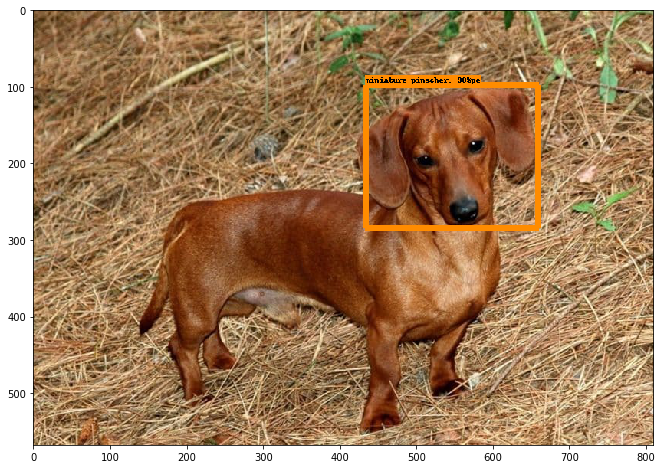

In [0]:
%cd ~/models/research/object_detection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if tf.__version__ < '1.4.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/datalab/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/datalab', 'label_map.pbtxt')

NUM_CLASSES = 37




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
print('hero')
    
with tf.Session() as sess:
  # `sess.graph` provides access to the graph used in a `tf.Session`.
  writer = tf.summary.FileWriter("./hero", sess.graph)    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
        
  return output_dict



for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  

In [0]:
%cd ~
!zip -r /root/newfile.zip /root/datalab/pretrained_model

from google.colab import files
files.download('/root/newfile.zip')


# # !rm -r /root/datalab




# import tensorflow as tf


# LOG_DIR = '/root/datalab/pretrained_model'



# !tensorboard --logdir=LOG_DIR


# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )


# get_ipython().system_raw('./ngrok http 6006 &')
# # One last step, we get the public URL where we can access the colab TensorBoard web page.

# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

/root
  adding: root/datalab/pretrained_model/ (stored 0%)
  adding: root/datalab/pretrained_model/checkpoint (deflated 42%)
  adding: root/datalab/pretrained_model/frozen_inference_graph.pb (deflated 13%)
  adding: root/datalab/pretrained_model/pipeline.config (deflated 68%)
  adding: root/datalab/pretrained_model/saved_model/ (stored 0%)
  adding: root/datalab/pretrained_model/saved_model/variables/ (stored 0%)
  adding: root/datalab/pretrained_model/saved_model/saved_model.pb (deflated 14%)
  adding: root/datalab/pretrained_model/model.ckpt.index (deflated 70%)
  adding: root/datalab/pretrained_model/model.ckpt.meta (deflated 95%)
  adding: root/datalab/pretrained_model/model.ckpt.data-00000-of-00001 (deflated 7%)
----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 55548, 0, 0)
----------------------------------------


Traceback (most recent call last):
  File "/usr/lib/python2.7/SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python2.7/SocketServer.py", line 654, in __init__
    self.finish()
  File "/usr/lib/python2.7/SocketServer.py", line 713, in finish
    self.wfile.close()
  File "/usr/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/usr/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe


In [0]:

%cd ~/datalab

LOGDIR = '/root/datalab/pretrained_model'



#Todo
import tensorflow as tf
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    model_filename ='/root/datalab/fine_tuned_model/frozen_inference_graph.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        g_in = tf.import_graph_def(graph_def)
LOGDIR='/root/datalab/fine_tuned_model'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)





In [0]:
%cd ~
# !rm -r *

/root
